In [1]:
"""
ADVANCED IMPUTATION METHODS FOR COMPETITOR PRICING DATA
========================================================
This notebook implements and compares advanced imputation methods:
1. KNN Imputation (K=5 similar observations)
2. MICE/Iterative Imputation (models each feature)
3. Time-series Forward Fill with Exponential Decay
4. Baseline (current method for comparison)

Output: improved_lagged_predictive_dataset.csv
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Imputation libraries
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

ADVANCED IMPUTATION METHODS - COMPETITOR PRICING DATA

SECTION 1: DATA LOADING

Raw competitor data loaded: (1820, 5)
Date range: 2025-09-16 00:00:00 to 2026-09-14 00:00:00
Missing values: 30 (1.6%)

Missing data by hotel:
                                                    total_obs  missing_count  \
hotel_id                                                                       
booking-us-aqua-pacific-monarch-USD                       348             16   
booking-us-courtyard-by-marriott-maui-kahului-a...        353             11   
booking-us-kohea-kai-resort-maui-USD                      362              2   
booking-us-ohana-waikiki-malia-USD                        363              1   

                                                    missing_rate  
hotel_id                                                          
booking-us-aqua-pacific-monarch-USD                     0.045977  
booking-us-courtyard-by-marriott-maui-kahului-a...      0.031161  
booking-us-kohea-kai-resort-

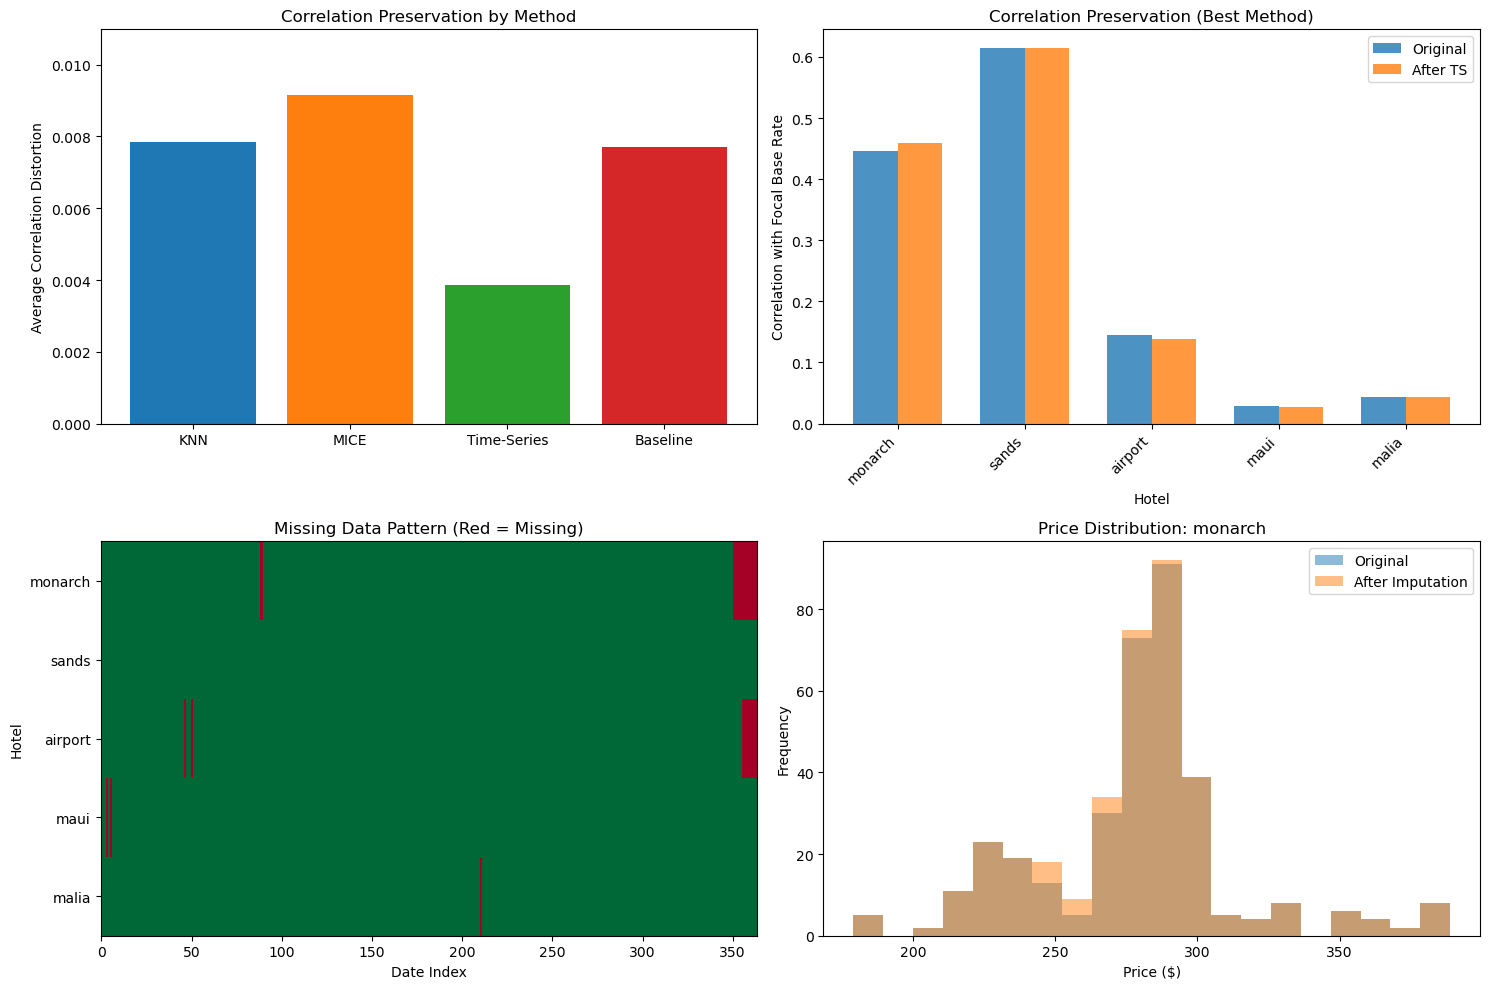

In [2]:
print("="*80)
print("ADVANCED IMPUTATION METHODS - COMPETITOR PRICING DATA")
print("="*80)

# ============================================================================
# SECTION 1: LOAD PREPROCESSED DATA
# ============================================================================
print("\n" + "="*80)
print("SECTION 1: DATA LOADING")
print("="*80)

data_path = Path('../data/dataprocessed')

# Load the cleaned data (after outlier removal but BEFORE imputation)
df_competitors = pd.read_csv('../../data/dataraw/data-1757985744315.csv')
df_competitors['stay_date'] = pd.to_datetime(df_competitors['stay_date'])

print(f"\nRaw competitor data loaded: {df_competitors.shape}")
print(f"Date range: {df_competitors['stay_date'].min()} to {df_competitors['stay_date'].max()}")
print(f"Missing values: {df_competitors['price'].isnull().sum()} ({df_competitors['price'].isnull().sum()/len(df_competitors)*100:.1f}%)")

# Missing data analysis
missing_by_hotel = df_competitors.groupby('hotel_id').agg({
    'price': ['count', lambda x: x.isnull().sum()]
})
missing_by_hotel.columns = ['total_obs', 'missing_count']
missing_by_hotel['missing_rate'] = missing_by_hotel['missing_count'] / missing_by_hotel['total_obs']

print("\nMissing data by hotel:")
print(missing_by_hotel[missing_by_hotel['missing_count'] > 0])

# ============================================================================
# SECTION 2: PREPARE DATA MATRIX FOR IMPUTATION
# ============================================================================
print("\n" + "="*80)
print("SECTION 2: DATA MATRIX PREPARATION")
print("="*80)

# Create price matrix (dates × hotels)
price_matrix = df_competitors.pivot(
    index='stay_date',
    columns='hotel_id',
    values='price'
)

print(f"\nPrice matrix shape: {price_matrix.shape}")
print(f"Total cells: {price_matrix.size}")
print(f"Missing cells: {price_matrix.isnull().sum().sum()} ({price_matrix.isnull().sum().sum()/price_matrix.size*100:.1f}%)")

# Store original correlations with target (we'll check if imputations preserve these)
# We need the focal hotel data for this
df_focal = pd.read_csv('../../data/dataraw/data-1757985699237.csv')
df_focal['stay_date'] = pd.to_datetime(df_focal['stay_date'])
focal_base = df_focal.groupby('stay_date')['price'].min().reset_index()
focal_base.columns = ['stay_date', 'base_rate']

# Merge with price matrix
price_matrix_with_target = price_matrix.merge(
    focal_base.set_index('stay_date'),
    left_index=True,
    right_index=True,
    how='inner'
)

original_correlations = price_matrix_with_target.drop('base_rate', axis=1).corrwith(
    price_matrix_with_target['base_rate']
)

print("\nOriginal correlations with focal hotel base rate:")
print(original_correlations.sort_values(ascending=False))

# ============================================================================
# SECTION 3: IMPUTATION METHOD 1 - KNN
# ============================================================================
print("\n" + "="*80)
print("SECTION 3: KNN IMPUTATION (K=5)")
print("="*80)

# KNN imputes based on the 5 most similar observations
knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
price_matrix_knn = pd.DataFrame(
    knn_imputer.fit_transform(price_matrix),
    index=price_matrix.index,
    columns=price_matrix.columns
)

# Check correlation preservation
price_matrix_knn_with_target = price_matrix_knn.merge(
    focal_base.set_index('stay_date'),
    left_index=True,
    right_index=True,
    how='inner'
)

knn_correlations = price_matrix_knn_with_target.drop('base_rate', axis=1).corrwith(
    price_matrix_knn_with_target['base_rate']
)

correlation_distortion_knn = (knn_correlations - original_correlations).abs()

print(f"\nKNN Imputation Results:")
print(f"  Missing values filled: {price_matrix.isnull().sum().sum()}")
print(f"  Average correlation distortion: {correlation_distortion_knn.mean():.4f}")
print(f"  Max correlation distortion: {correlation_distortion_knn.max():.4f}")

# ============================================================================
# SECTION 4: IMPUTATION METHOD 2 - MICE (Iterative)
# ============================================================================
print("\n" + "="*80)
print("SECTION 4: MICE IMPUTATION (Iterative)")
print("="*80)

# MICE models each feature as a function of others
mice_imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=10, random_state=42),
    max_iter=10,
    random_state=42
)

price_matrix_mice = pd.DataFrame(
    mice_imputer.fit_transform(price_matrix),
    index=price_matrix.index,
    columns=price_matrix.columns
)

# Check correlation preservation
price_matrix_mice_with_target = price_matrix_mice.merge(
    focal_base.set_index('stay_date'),
    left_index=True,
    right_index=True,
    how='inner'
)

mice_correlations = price_matrix_mice_with_target.drop('base_rate', axis=1).corrwith(
    price_matrix_mice_with_target['base_rate']
)

correlation_distortion_mice = (mice_correlations - original_correlations).abs()

print(f"\nMICE Imputation Results:")
print(f"  Missing values filled: {price_matrix.isnull().sum().sum()}")
print(f"  Average correlation distortion: {correlation_distortion_mice.mean():.4f}")
print(f"  Max correlation distortion: {correlation_distortion_mice.max():.4f}")

# ============================================================================
# SECTION 5: IMPUTATION METHOD 3 - TIME-SERIES FORWARD FILL WITH DECAY
# ============================================================================
print("\n" + "="*80)
print("SECTION 5: TIME-SERIES FORWARD FILL WITH DECAY")
print("="*80)

# For each hotel, if price is missing, use previous price * decay_factor
# Decay factor = 0.99 per day (assumes prices don't change drastically)
price_matrix_ts = price_matrix.copy()

for hotel_id in price_matrix_ts.columns:
    hotel_prices = price_matrix_ts[hotel_id].copy()
    
    # Forward fill with exponential decay
    last_valid_price = None
    days_since_valid = 0
    
    for idx in hotel_prices.index:
        if pd.isna(hotel_prices[idx]):
            if last_valid_price is not None:
                days_since_valid += 1
                # Apply decay: each day missing, assume 1% price drift
                decay_factor = 0.99 ** days_since_valid
                hotel_prices[idx] = last_valid_price * decay_factor
        else:
            last_valid_price = hotel_prices[idx]
            days_since_valid = 0
    
    # Backward fill for any remaining NaNs at the start
    hotel_prices = hotel_prices.bfill()
    
    # If still NaN (entire series was NaN), use median
    if hotel_prices.isnull().any():
        hotel_prices = hotel_prices.fillna(price_matrix[hotel_id].median())
    
    price_matrix_ts[hotel_id] = hotel_prices

# Check correlation preservation
price_matrix_ts_with_target = price_matrix_ts.merge(
    focal_base.set_index('stay_date'),
    left_index=True,
    right_index=True,
    how='inner'
)

ts_correlations = price_matrix_ts_with_target.drop('base_rate', axis=1).corrwith(
    price_matrix_ts_with_target['base_rate']
)

correlation_distortion_ts = (ts_correlations - original_correlations).abs()

print(f"\nTime-Series Imputation Results:")
print(f"  Missing values filled: {price_matrix.isnull().sum().sum()}")
print(f"  Average correlation distortion: {correlation_distortion_ts.mean():.4f}")
print(f"  Max correlation distortion: {correlation_distortion_ts.max():.4f}")

# ============================================================================
# SECTION 6: IMPUTATION METHOD 4 - BASELINE (Current Method)
# ============================================================================
print("\n" + "="*80)
print("SECTION 6: BASELINE IMPUTATION (Current Method)")
print("="*80)

# Replicate the current method from 02_Data_Preprocessing.ipynb
price_matrix_baseline = price_matrix.copy()

for hotel_id in price_matrix_baseline.columns:
    # Forward fill
    price_matrix_baseline[hotel_id] = price_matrix_baseline[hotel_id].fillna(method='ffill')
    # Backward fill
    price_matrix_baseline[hotel_id] = price_matrix_baseline[hotel_id].fillna(method='bfill')
    # Linear interpolation
    price_matrix_baseline[hotel_id] = price_matrix_baseline[hotel_id].interpolate(method='linear')
    # Hotel median as last resort
    price_matrix_baseline[hotel_id] = price_matrix_baseline[hotel_id].fillna(
        price_matrix[hotel_id].median()
    )

# Check correlation preservation
price_matrix_baseline_with_target = price_matrix_baseline.merge(
    focal_base.set_index('stay_date'),
    left_index=True,
    right_index=True,
    how='inner'
)

baseline_correlations = price_matrix_baseline_with_target.drop('base_rate', axis=1).corrwith(
    price_matrix_baseline_with_target['base_rate']
)

correlation_distortion_baseline = (baseline_correlations - original_correlations).abs()

print(f"\nBaseline Imputation Results:")
print(f"  Missing values filled: {price_matrix.isnull().sum().sum()}")
print(f"  Average correlation distortion: {correlation_distortion_baseline.mean():.4f}")
print(f"  Max correlation distortion: {correlation_distortion_baseline.max():.4f}")

# ============================================================================
# SECTION 7: COMPARISON AND BEST METHOD SELECTION
# ============================================================================
print("\n" + "="*80)
print("SECTION 7: IMPUTATION METHOD COMPARISON")
print("="*80)

comparison_results = pd.DataFrame({
    'Method': ['KNN (K=5)', 'MICE (Iterative)', 'Time-Series Decay', 'Baseline (Current)'],
    'Avg_Correlation_Distortion': [
        correlation_distortion_knn.mean(),
        correlation_distortion_mice.mean(),
        correlation_distortion_ts.mean(),
        correlation_distortion_baseline.mean()
    ],
    'Max_Correlation_Distortion': [
        correlation_distortion_knn.max(),
        correlation_distortion_mice.max(),
        correlation_distortion_ts.max(),
        correlation_distortion_baseline.max()
    ]
})

comparison_results = comparison_results.sort_values('Avg_Correlation_Distortion')

print("\nComparison Results (Lower distortion = Better):")
print(comparison_results.to_string(index=False))

best_method = comparison_results.iloc[0]['Method']
print(f"\n{'='*80}")
print(f"BEST METHOD: {best_method}")
print(f"{'='*80}")

# Select the best imputed matrix
if best_method == 'KNN (K=5)':
    price_matrix_final = price_matrix_knn
elif best_method == 'MICE (Iterative)':
    price_matrix_final = price_matrix_mice
elif best_method == 'Time-Series Decay':
    price_matrix_final = price_matrix_ts
else:
    price_matrix_final = price_matrix_baseline

# ============================================================================
# SECTION 8: VISUALIZATION
# ============================================================================
print("\n" + "="*80)
print("SECTION 8: VISUALIZATION")
print("="*80)

# Create results directory if it doesn't exist
results_path = Path('../results')
results_path.mkdir(parents=True, exist_ok=True)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Correlation preservation comparison
methods = ['KNN', 'MICE', 'Time-Series', 'Baseline']
avg_distortions = [
    correlation_distortion_knn.mean(),
    correlation_distortion_mice.mean(),
    correlation_distortion_ts.mean(),
    correlation_distortion_baseline.mean()
]

axes[0, 0].bar(methods, avg_distortions, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0, 0].set_ylabel('Average Correlation Distortion')
axes[0, 0].set_title('Correlation Preservation by Method')
axes[0, 0].set_ylim(0, max(avg_distortions) * 1.2)

# Plot 2: Correlation comparison (before vs after best method)
hotel_names = [h.split('-')[-2] for h in original_correlations.index]
x = np.arange(len(hotel_names))
width = 0.35

axes[0, 1].bar(x - width/2, original_correlations.values, width, label='Original', alpha=0.8)
if best_method == 'KNN (K=5)':
    axes[0, 1].bar(x + width/2, knn_correlations.values, width, label='After KNN', alpha=0.8)
elif best_method == 'MICE (Iterative)':
    axes[0, 1].bar(x + width/2, mice_correlations.values, width, label='After MICE', alpha=0.8)
elif best_method == 'Time-Series Decay':
    axes[0, 1].bar(x + width/2, ts_correlations.values, width, label='After TS', alpha=0.8)
else:
    axes[0, 1].bar(x + width/2, baseline_correlations.values, width, label='After Baseline', alpha=0.8)

axes[0, 1].set_xlabel('Hotel')
axes[0, 1].set_ylabel('Correlation with Focal Base Rate')
axes[0, 1].set_title('Correlation Preservation (Best Method)')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(hotel_names, rotation=45, ha='right')
axes[0, 1].legend()

# Plot 3: Missing data heatmap (before imputation)
missing_matrix = price_matrix.isnull().astype(int)
axes[1, 0].imshow(missing_matrix.T, aspect='auto', cmap='RdYlGn_r', interpolation='nearest')
axes[1, 0].set_xlabel('Date Index')
axes[1, 0].set_ylabel('Hotel')
axes[1, 0].set_title('Missing Data Pattern (Red = Missing)')
axes[1, 0].set_yticks(range(len(price_matrix.columns)))
axes[1, 0].set_yticklabels([h.split('-')[-2] for h in price_matrix.columns])

# Plot 4: Price distributions comparison
hotel_sample = price_matrix.columns[0]  # Pick first hotel for example
axes[1, 1].hist(price_matrix[hotel_sample].dropna(), bins=20, alpha=0.5, label='Original')
axes[1, 1].hist(price_matrix_final[hotel_sample], bins=20, alpha=0.5, label='After Imputation')
axes[1, 1].set_xlabel('Price ($)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(f'Price Distribution: {hotel_sample.split("-")[-2]}')
axes[1, 1].legend()

plt.tight_layout()
results_file = results_path / 'imputation_comparison.png'
plt.savefig(str(results_file), dpi=300, bbox_inches='tight')
print(f"\nVisualization saved: {results_file}")

# Create processed data directory if needed
processed_path = Path('../../data/dataprocessed')
processed_path.mkdir(parents=True, exist_ok=True)

print("\n" + "="*80)
print("SECTION 8.5: DATE RANGE VALIDATION & FIX - ALL METHODS")
print("="*80)

# Load baseline to get correct date range
baseline_matrix = pd.read_csv(processed_path / 'competitor_price_matrix.csv')
baseline_dates = set(pd.to_datetime(baseline_matrix['stay_date']))

# Fix all 4 imputation methods
imputation_matrices = {
    'KNN': price_matrix_knn,
    'MICE': price_matrix_mice,
    'Time-Series': price_matrix_ts,
    'Baseline': price_matrix_baseline
}

for method_name, price_matrix in imputation_matrices.items():
    print(f"\nChecking {method_name}...")
    
    imputed_dates = set(price_matrix.index)
    missing_dates = baseline_dates - imputed_dates
    
    if missing_dates:
        print(f"  Missing {len(missing_dates)} dates, fixing...")
        for missing_date in sorted(missing_dates):
            print(f"    Adding: {missing_date.date()}")
        
        # Create complete date range
        all_dates = pd.date_range(
            start=price_matrix.index.min(),
            end=max(price_matrix.index.max(), max(missing_dates)),
            freq='D'
        )
        
        # Reindex and forward-fill
        if method_name == 'KNN':
            price_matrix_knn = price_matrix_knn.reindex(all_dates).fillna(method='ffill')
            price_matrix_knn.index.name = 'stay_date'
            print(f"  Fixed KNN: {len(price_matrix_knn)} rows")
        elif method_name == 'MICE':
            price_matrix_mice = price_matrix_mice.reindex(all_dates).fillna(method='ffill')
            price_matrix_mice.index.name = 'stay_date'
            print(f"  Fixed MICE: {len(price_matrix_mice)} rows")
        elif method_name == 'Time-Series':
            price_matrix_ts = price_matrix_ts.reindex(all_dates).fillna(method='ffill')
            price_matrix_ts.index.name = 'stay_date'
            print(f"  Fixed Time-Series: {len(price_matrix_ts)} rows")
        elif method_name == 'Baseline':
            price_matrix_baseline = price_matrix_baseline.reindex(all_dates).fillna(method='ffill')
            price_matrix_baseline.index.name = 'stay_date'
            print(f"  Fixed Baseline: {len(price_matrix_baseline)} rows")
    else:
        print(f"Date range OK: {len(price_matrix)} rows")

print("\n All methods validated and fixed")

# ============================================================================
# SECTION 9: EXPORT ALL IMPUTATION METHODS
# ============================================================================
print("\n" + "="*80)
print("SECTION 9: EXPORT ALL IMPUTATION METHODS")
print("="*80)


# Dictionary of all 4 imputation results from Sections 3-6
imputation_methods = {
    'knn': price_matrix_knn,
    'mice': price_matrix_mice,
    'timeseries': price_matrix_ts,
    'baseline': price_matrix_baseline
}

for method_name, price_matrix_result in imputation_methods.items():
    print(f"\n{'='*80}")
    print(f"Exporting {method_name.upper()} imputation")
    print(f"{'='*80}")
    
    # Convert to long format
    price_matrix_long = price_matrix_result.reset_index().melt(
        id_vars=['stay_date'],
        var_name='hotel_id',
        value_name='price'
    )
    
    # Merge with other competitor data
    df_competitors_method = df_competitors.drop('price', axis=1).merge(
        price_matrix_long,
        on=['stay_date', 'hotel_id'],
        how='left'
    )
    
    # Export long format
    df_competitors_method.to_csv(
        processed_path / f'competitors_{method_name}.csv',
        index=False
    )
    print(f"Saved: competitors_{method_name}.csv")
    print(f"  Shape: {df_competitors_method.shape}")
    print(f"  Missing values: {df_competitors_method['price'].isnull().sum()}")
    
    # Export price matrix (wide format)
    price_matrix_result.to_csv(
        processed_path / f'competitor_price_matrix_{method_name}.csv'
    )
    print(f"Saved: competitor_price_matrix_{method_name}.csv")

# Save overall comparison metadata
imputation_metadata = {
    'best_method': best_method,
    'comparison_results': comparison_results.to_dict('records'),
    'original_missing_count': int(price_matrix.isnull().sum().sum()),
    'missing_percentage': float(price_matrix.isnull().sum().sum() / price_matrix.size * 100),
    'correlation_preservation': {
        'knn_avg': float(correlation_distortion_knn.mean()),
        'mice_avg': float(correlation_distortion_mice.mean()),
        'timeseries_avg': float(correlation_distortion_ts.mean()),
        'baseline_avg': float(correlation_distortion_baseline.mean())
    },
    'original_correlations': original_correlations.to_dict()
}

with open(processed_path / 'imputation_comparison_metadata.json', 'w') as f:
    json.dump(imputation_metadata, f, indent=2)
print(f"\nSaved: imputation_comparison_metadata.json")

print("\n" + "="*80)
print("ALL IMPUTATION METHODS EXPORTED")
print("="*80)
print(f"\nBest method identified: {best_method}")
print(f"\nFiles exported for each method (knn, mice, timeseries, baseline):")
print(f"  - competitors_[method].csv")
print(f"  - competitor_price_matrix_[method].csv")
print(f"\nNext step: Create lag datasets for each imputation method")